In [1]:
library(dplyr)
library(ggplot2)
library(ggpubr)
library(unikn)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome to unikn (v0.8.0)!

usecol() allows changing and using color palettes.



In [3]:
citation('amap')


To cite package ‘amap’ in publications use:

  Lucas A (2022). _amap: Another Multidimensional Analysis Package_. R
  package version 0.8-19, <https://CRAN.R-project.org/package=amap>.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {amap: Another Multidimensional Analysis Package},
    author = {Antoine Lucas},
    year = {2022},
    note = {R package version 0.8-19},
    url = {https://CRAN.R-project.org/package=amap},
  }

ATTENTION: This citation information has been auto-generated from the
package DESCRIPTION file and may need manual editing, see
‘help("citation")’.




In [2]:
annot <- data.table::fread('../data/final_annotation_table.tsv', sep='\t', data.table=F)

In [3]:
annot$Age <- factor(annot$Age, levels=rev(c('Total',unique(sort(annot$Age)))))

In [4]:
ordered <- c(
 'vRG E',
 'vRG L',
 'tRG',
 'tRG EOMES+',
 'Epen',
 'oRG E',
 'oRG L',
 'nIPC',
 'Neu E',
 'IN',
 'mGPC',
 'Astro',
 'OPC',
 'Oligo',
 'LQ RGC'
)


In [40]:
viridis::magma(n=5)[-1]

[1] "#51127CFF" "#B63679FF" "#FB8861FF" "#FCFDBFFF"

In [5]:
ordered_clusters <- c('Cyc. Prog.', 'Early RG', 'Late RG', 'tRG', 'nIPC', 'mGPC', 'OPC/Oligo')


In [6]:
final_annot <- subset(annot, reannot)

In [7]:
final_annot$final_annotation <- factor(as.character(final_annot$final_annotation), levels=names(rev(sort(table(final_annot$final_annotation)))))
final_annot$final_annotation <- factor(as.character(final_annot$final_annotation), levels=rev(ordered))
final_annot$Cluster.Name <- factor(as.character(final_annot$Cluster.Name), levels=rev(ordered_clusters))

In [34]:
sizes_annot <- table(final_annot[c('final_annotation', 'Age')])
sizes_annot <- subset(do.call('rbind', apply(sizes_annot, 1, function(x){
    d <- rbind(
        data.frame(
            Age=factor(rev(names(x)), levels=levels(final_annot$Age)),
            N=rev(x), 
            C=cumsum(rev(x))),
        data.frame(
            Age=factor('Total', levels=levels(final_annot$Age)),
            N=sum(x), 
            C=sum(x)*-0.1
        ))

    d$rel_C <- d$C/sum(x)
    d
})), N!= 0)

sizes_annot$ct <- factor(sapply(strsplit(rownames(sizes_annot), split='.', fixed=T), function(x){x[1]}), levels=levels(final_annot$final_annotation))

age.bp <- ggplot(final_annot) +
    geom_bar(aes(y=final_annotation, fill=Age), color='black', position='fill') +
    geom_text_repel(data=subset(sizes_annot, N!=0),
              min.segment.length = 0,
               direction = "x", 
                    # nudge_x=0.02, 
               aes(x=rel_C, y=ct, 
                   label=N, 
                   color=ifelse(Age%in%c('pcw16', 'pcw20'), 'white', 'black'),
                   fill=Age,
                   hjust=ifelse((rel_C<0.2) | rel_C==1, 1, 0))) + 
    scale_fill_manual('Age',values=setNames(c('white', viridis::magma(n=5)[-1]), 
                                            rev(levels(final_annot$Age)))) +
    scale_color_identity(guide = guide_none()) +
    theme_pubr() + labs_pubr() +
    labs(x='% of cells', y='Annotation') + 
    theme(text=element_text(family='ArialMT')) + 
    scale_x_continuous(expand=expansion(add = c(0.05, .1)), breaks=seq(from=0,to=1,by = 0.2))

age.bp

In [36]:

sizes_annot <- table(final_annot[c('final_annotation', 'Cluster.Name')])
sizes_annot <- subset(do.call('rbind', apply(sizes_annot, 1, function(x){
    d <- rbind(
        data.frame(
            Cluster.Name=rev(names(x)),
            Prop=rev(x)/sum(x),
            N=rev(x), 
            C=cumsum(rev(x))),
        data.frame(
            Cluster.Name='Total',
            Prop=1,
            N=sum(x), 
            C=sum(x)*-0
        ))

    d$rel_C <- d$C/sum(x)
    d
})), Prop>0.1)

sizes_annot$ct <- factor(sapply(strsplit(rownames(sizes_annot), split='.', fixed=T), function(x){x[1]}), levels=levels(final_annot$final_annotation))

clusters.palette <- setNames(c('white', unlist(unname(unikn::pal_unikn_pref))[c(6,4,2,7,3,1,5)]),
                                      c('Total', rev(levels(final_annot$Cluster.Name)))) 
clusters.palette

clusters.bp <- ggplot(final_annot) +
    geom_bar(aes(y=final_annotation, fill=Cluster.Name), color='black', position='fill') +
    geom_text_repel(data=subset(sizes_annot, N!=0 & Cluster.Name!='Total'),
              min.segment.length = 0,
               direction = "x", 
                    # nudge_x=0.02, 
               aes(x=rel_C, y=ct, 
                   label=N, 
                   # color=ifelse(Age%in%c('pcw16', 'pcw20'), 'white', 'black'),
                   fill=Cluster.Name,
                   hjust=ifelse(rel_C<0.05, 0, 0))) + 
    scale_fill_manual('Trevino et al.\nnaming',
                      values=clusters.palette) +
    scale_color_identity(guide = guide_none()) +
    theme_pubr() + labs_pubr() +
    labs(x='% of cells', y='Annotation') + 
    theme(text=element_text(family='ArialMT')) + 
    scale_x_continuous(
        # expand=expansion(add = c(0.1, .1)), 
        breaks=seq(from=0,to=1,by = 0.2))

clusters.bp

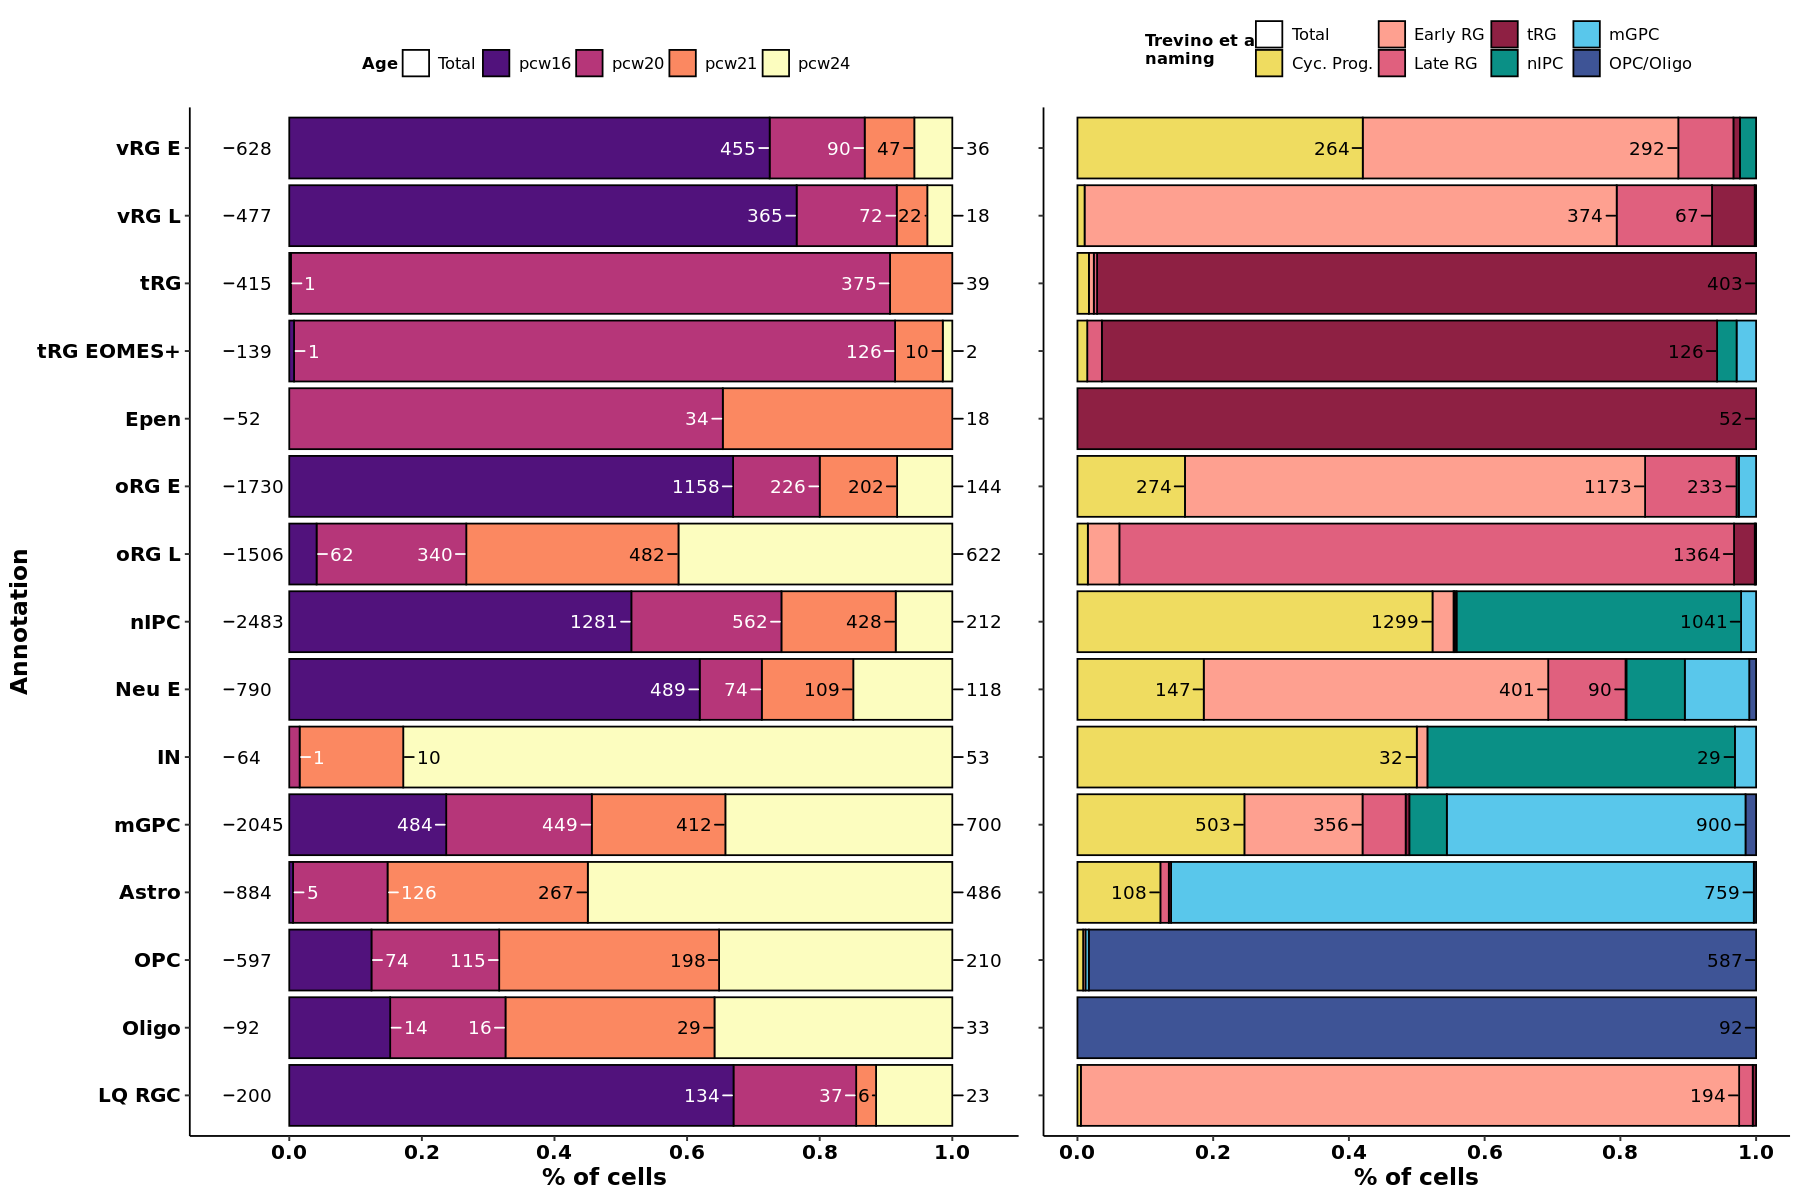

In [38]:
options(repr.plot.width=15, repr.plot.height=10)

combined_barplot <- cowplot::plot_grid(age.bp, 
                   clusters.bp + ylab(NULL) + theme(axis.text.y = element_blank()),
                   ncol = 2, align='h', axis='tb', rel_widths = c(1,0.75)
                    # ncol = 1, align='v', axis='lr'
                  )
plot(combined_barplot)


In [39]:
pdf('./../Annotation.Barplots.pdf', width=15, height=7, useDingbats = F, family = 'ArialMT')
plot(combined_barplot)
dev.off()

png 
  2